# Change signal

Assessment of model change signal over the future period relative to the historical.


In [1]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=logging.CRITICAL)
import string

import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

import sys
#sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
import utils

In [2]:
outdir = '/g/data/ia39/npcp/code/results/figures/'

In [3]:
def calc_change_signal(da_future, da, var):
    """Calculate the difference in the change signal between GCM and RCM """
    
    if var == 'pr':
        future_annual_mean = da_future.groupby('time.year').sum(dim="time").mean(dim='year')
        base_annual_mean = da.groupby('time.year').sum(dim="time").mean(dim='year')
        change_signal = ((future_annual_mean - base_annual_mean) / base_annual_mean) * 100
    else:
        future_annual_mean = da_future.groupby('time.year').mean(dim="time").mean(dim='year')
        base_annual_mean = da.groupby('time.year').mean(dim="time").mean(dim='year')
        change_signal = future_annual_mean - base_annual_mean
    
    return change_signal

In [4]:
def get_data(var, gcm, rcm):
    """Get data needed for the evaluation"""

    assert gcm in ['CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']

    start_date = '1980-01-01' 
    end_date = '2019-12-31'
    start_date_future = '2060-01-01'
    end_date_future = '2099-12-31'

    da_dict = {}

    try:
        da_dict['gcm'] = utils.get_npcp_data(
            var,
            gcm,
            'GCM',
            'raw',
            'task-reference',
            start_date,
            end_date,
        )
    except OSError as e:
        print(f"Warning: {e}")
        da_dict['gcm'] = None

    try:
        da_dict['gcm_future'] = utils.get_npcp_data(
            var,
            gcm,
            'GCM',
            'raw',
            'task-reference',
            start_date_future,
            end_date_future,
        )
    except OSError as e:
        print(f"Warning: {e}")
        da_dict['gcm_future'] = None
    
    try:
        da_dict['rcm_raw'] = utils.get_npcp_data(
            var,
            gcm,
            rcm,
            'raw',
            'task-reference',
            start_date,
            end_date,
        )
    except OSError as e:
        print(f"Warning: {e}")
        da_dict['rcm_raw'] = None

    try:
        da_dict['rcm_raw_future'] = utils.get_npcp_data(
            var,
            gcm,
            rcm,
            'raw',
            'task-reference',
            start_date_future,
            end_date_future,
        )
    except OSError as e:
        print(f"Warning: {e}")
        da_dict['rcm_raw_future'] = None

    for bc in ['ecdfm', 'qme', 'mbcn', 'mrnbc']:
        try:
            da_dict[f'rcm_{bc}'] = utils.get_npcp_data(
                var,
                gcm,
                rcm,
                bc,
                f'task-historical',
                start_date,
                end_date,
            )
        except OSError as e:
            print(f"Warning: {e}")
            da_dict[f'rcm_{bc}'] = None

        try:
            da_dict[f'rcm_{bc}_future'] = utils.get_npcp_data(
                var,
                gcm,
                rcm,
                bc,
                'task-projection',
                start_date_future,
                end_date_future,
            )
        except OSError as e:
            print(f"Warning: {e}")
            da_dict[f'rcm_{bc}_future'] = None

    try:
        da_dict['rcm_qdc'] = utils.get_npcp_data(
            var,
            'observations',
            'AGCD',
            'raw',
            f'task-reference',
            start_date,
            end_date,
        )
    except OSError as e:
        print(f"Warning: {e}")
        da_dict['rcm_qdc'] = None

    try:
        da_dict['rcm_qdc_future'] = utils.get_npcp_data(
            var,
            gcm,
            rcm,
            'qdc',
            'task-projection',
            start_date_future,
            end_date_future,
        )
    except OSError as e:
        print(f"Warning: {e}")
        da_dict['rcm_qdc_future'] = None

    return da_dict


In [5]:
def plot_change_signal(
    ax,
    da_model_future,
    da_model,
    var,
    cmap,
    levels,
    model_name,
    letter_index,
    ob_fractions=None
):
    """Plot the change signal for a particular model"""
    
    change_signal = calc_change_signal(da_model_future, da_model, var) 

    change_signal = utils.clip_data(change_signal, utils.get_aus_shape())
    if ob_fractions is not None:
        change_signal = utils.mask_by_pr_ob_fraction(change_signal, ob_fractions, threshold=0.9)  

    if var == 'pr':
        units = '%' 
        spatial_average = None
    else:
        units = da_model.attrs['units']
    spatial_average = np.nanmean(change_signal) 

    im = change_signal.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both',
        add_colorbar=False,
#        cbar_kwargs={'label': units},
    )
    cb = plt.colorbar(im)
    cb.set_label(label=units, size='x-large')
    cb.ax.tick_params(labelsize='x-large')
    letter = string.ascii_lowercase[letter_index]
    ax.text(0.02, 0.92, f'({letter})', transform=ax.transAxes, fontsize='xx-large')
    ax.text(0.02, 0.02, f'spatial average: {spatial_average:.2f} {units}', transform=ax.transAxes, fontsize='x-large')
    ax.set_title(model_name, fontsize='xx-large')
    ax.coastlines()


def plot_rcm_difference(
    ax,
    change_signal_rcm,
    da_bias_future,
    da_bias,
    var,
    cmap,
    levels,
    model_name,
    letter_index,
    ob_fractions=None
):
    """Plot the difference between the raw RCM change and bias corrected RCM change"""
    
    change_signal_bias = calc_change_signal(da_bias_future, da_bias, var) 
    change_signal_diff = change_signal_bias - change_signal_rcm

    change_signal_diff = utils.clip_data(change_signal_diff, utils.get_aus_shape())
    if ob_fractions is not None:
        change_signal_diff = utils.mask_by_pr_ob_fraction(change_signal_diff, ob_fractions, threshold=0.9)  
    mae = np.nanmean(np.abs(change_signal_diff)) 
    
    units = '%' if var == 'pr' else 'C'
    
    im = change_signal_diff.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both',
        add_colorbar=False,
#        cbar_kwargs={'label': units},
    )
    cb = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.04)
    cb.set_label(label=units, size='x-large')
    cb.ax.tick_params(labelsize='x-large')
    letter = string.ascii_lowercase[letter_index]
    ax.text(0.02, 0.92, f'({letter})', transform=ax.transAxes, fontsize='xx-large')
    ax.text(0.02, 0.02, f'MAE: {mae:.2f} {units}', transform=ax.transAxes, fontsize='x-large')
    ax.set_title(model_name, fontsize='xx-large')
    ax.coastlines()

title_bc_names = {
    'ecdfm': 'ECDFm', 
    'qme': 'QME',
    'qdc': 'QDC',
    'mbcn': 'MBCn',
    'mrnbc': 'MRNBC',
}

model_labels = {
    'CSIRO-ACCESS-ESM1-5': 'ACCESS-ESM1-5',
    'NCAR-CESM2': 'CESM2',
    'EC-Earth-Consortium-EC-Earth3': 'EC-Earth3',
    'ECMWF-ERA5': 'ERA5',
    'BOM-BARPA-R': 'BARPA-R',
    'CSIRO-CCAM-2203': 'CCAM-v2203-SN',
    'UQ-DES-CCAM-2105': 'CCAM-v2105',
}


def plot_comparison(var, gcm, rcm, trend_cmap, diff_cmap, levels, rcm_levels=None, outfile=None, rcm_outfile=None):
    """Plot the complete comparison"""

    gcm_label = model_labels[gcm]
    rcm_label = model_labels[rcm]
    
    da_dict = get_data(var, gcm, rcm)
    if var == 'pr':
        ob_fractions = utils.get_pr_weights(gcm, 'historical')
    else:
        ob_fractions = None
 
  # Plot 1
    ncols = 4
    nrows = 3
    fig = plt.figure(figsize=[7 * ncols, 5 * nrows])
    plot_count = 1
    letter_index = 0

    if da_dict['gcm'] is not None and da_dict['gcm_future'] is not None:
        ax1 = fig.add_subplot(nrows, ncols, plot_count, projection=ccrs.PlateCarree())
        plot_change_signal(
            ax1, da_dict['gcm_future'], da_dict['gcm'], var, trend_cmap, levels, f'{gcm_label} (raw)', letter_index, ob_fractions=ob_fractions
        )
        letter_index = letter_index + 1
    plot_count += 4

    if da_dict['rcm_raw'] is not None and da_dict['rcm_raw_future'] is not None:
        ax2 = fig.add_subplot(nrows, ncols, plot_count, projection=ccrs.PlateCarree())
        plot_change_signal(
            ax2, da_dict['rcm_raw_future'], da_dict['rcm_raw'], var, trend_cmap, levels, f'{rcm_label} (raw)', letter_index, ob_fractions=ob_fractions
        )
        letter_index = letter_index + 1
    plot_count += 1

    for bc in ['ecdfm', 'qme', 'qdc', 'mbcn', 'mrnbc']:
        future_key = f'rcm_{bc}_future'
        past_key = f'rcm_{bc}'
        if da_dict.get(future_key) is not None and da_dict.get(past_key) is not None:
            ax = fig.add_subplot(nrows, ncols, plot_count, projection=ccrs.PlateCarree())
            title_bc_name = title_bc_names[bc]
            plot_change_signal(
                ax,
                da_dict[future_key],
                da_dict[past_key],
                var,
                trend_cmap,
                levels,
                f'{rcm_label} ({title_bc_name})',
                letter_index,
                ob_fractions=ob_fractions
            )
            letter_index = letter_index + 1
        if bc == 'qdc':
            plot_count += 2  
        else:
            plot_count += 1

    start_year = '1980'
    end_year = '2019'
    start_year_future = '2060'
    end_year_future = '2099'

    long_name = da_dict['rcm_raw'].attrs['long_name'].lower()
    print(f'change in annual mean {long_name} ({start_year_future}-{end_year_future} minus {start_year}-{end_year})')
    if outfile:
        print(outfile)
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()

    # Plot 2
    if rcm_levels is not None:
        change_signal_rcm = calc_change_signal(da_dict['rcm_raw_future'], da_dict['rcm_raw'], var)
        ncols = 5
        fig = plt.figure(figsize=[7 * ncols, 5])
        plot_count = 1
        letter_index = 0

        for bc in ['ecdfm', 'qme', 'qdc', 'mbcn', 'mrnbc']:
            future_key = f'rcm_{bc}_future'
            past_key = f'rcm_{bc}'
            title_bc_name = title_bc_names[bc]
            if da_dict.get(future_key) is not None and da_dict.get(past_key) is not None:
                ax = fig.add_subplot(1, ncols, plot_count, projection=ccrs.PlateCarree())
                plot_rcm_difference(
                    ax,
                    change_signal_rcm,
                    da_dict[future_key],
                    da_dict[past_key],
                    var,
                    diff_cmap,
                    rcm_levels,
                    f'{rcm_label} - {rcm_label} ({title_bc_name})',
                    letter_index,
                    ob_fractions=ob_fractions
                )
                letter_index = letter_index + 1
            plot_count += 1

        start_year = '1980'
        end_year = '2019'
        start_year_future = '2060'
        end_year_future = '2099'

        long_name = da_dict['rcm_raw'].attrs['long_name'].lower()
        print(f'change in annual mean {long_name} relative to {rcm}-raw (bias-corrected RCM change minus raw RCM change)')
        if rcm_outfile:
            print(rcm_outfile)
            plt.savefig(rcm_outfile, dpi=300, bbox_inches='tight')
        plt.show()

# task-projection

Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

In [6]:
variable = 'tasmax'
levels = np.arange(1.25, 4.76, 0.5)
rcm_levels = np.arange(-1.1, 1.101, 0.2)
trend_cmap = 'hot_r'
diff_cmap = 'RdBu_r'

### ACCESS-ESM1-5

In [7]:
gcm = 'CSIRO-ACCESS-ESM1-5'

change in annual mean daily maximum near-surface air temperature (2060-2099 minus 1980-2019)
/g/data/ia39/npcp/code/results/figures/tasmax_trend_task-projection_CSIRO-ACCESS-ESM1-5_BOM-BARPA-R.png


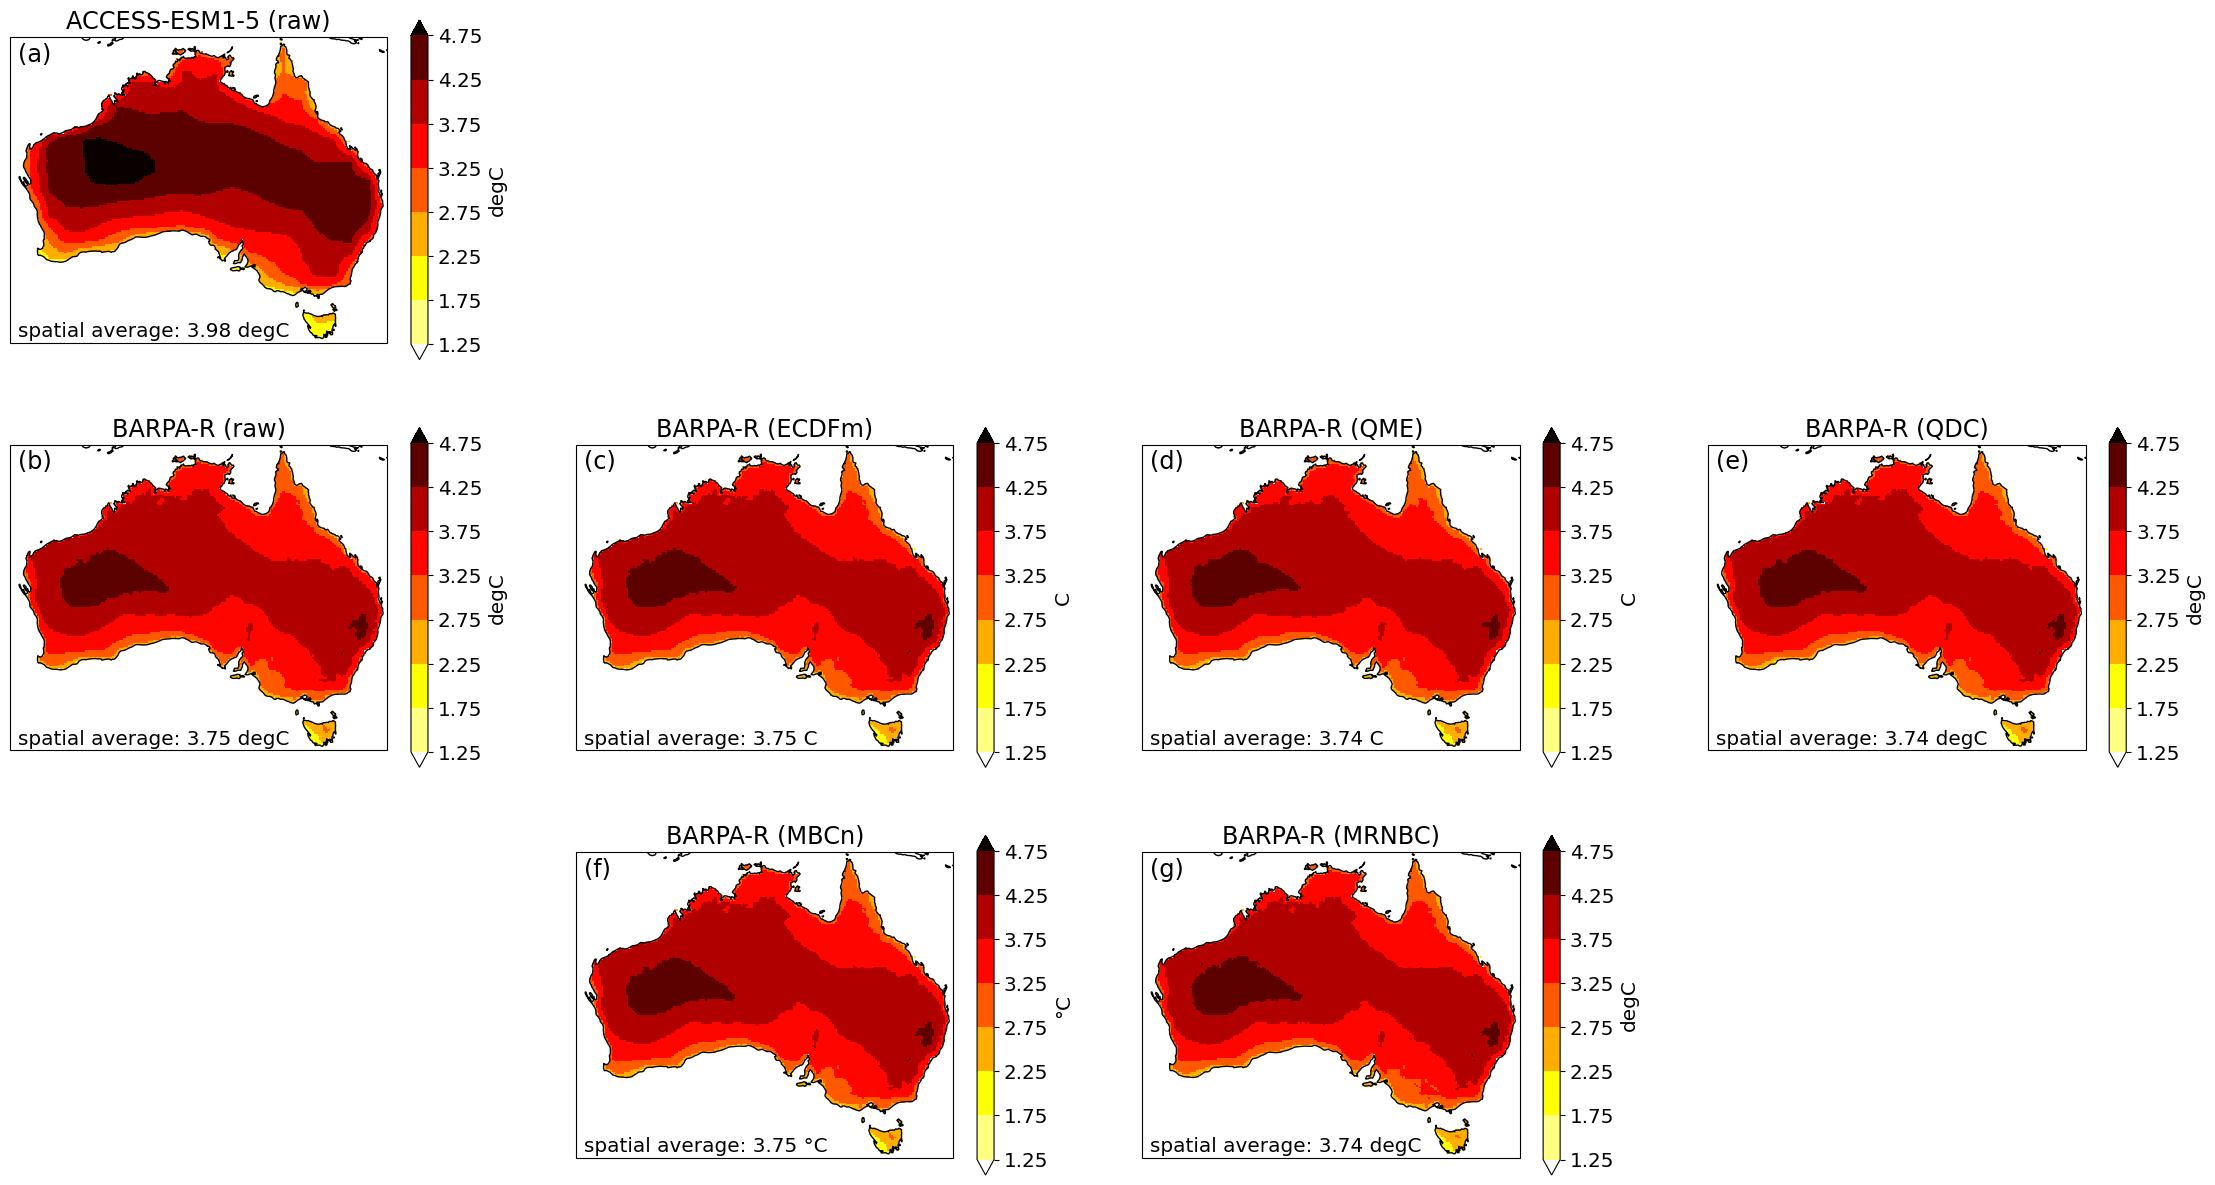

change in annual mean daily maximum near-surface air temperature relative to BOM-BARPA-R-raw (bias-corrected RCM change minus raw RCM change)
/g/data/ia39/npcp/code/results/figures/tasmax_trend-rcm_task-projection_CSIRO-ACCESS-ESM1-5_BOM-BARPA-R.png


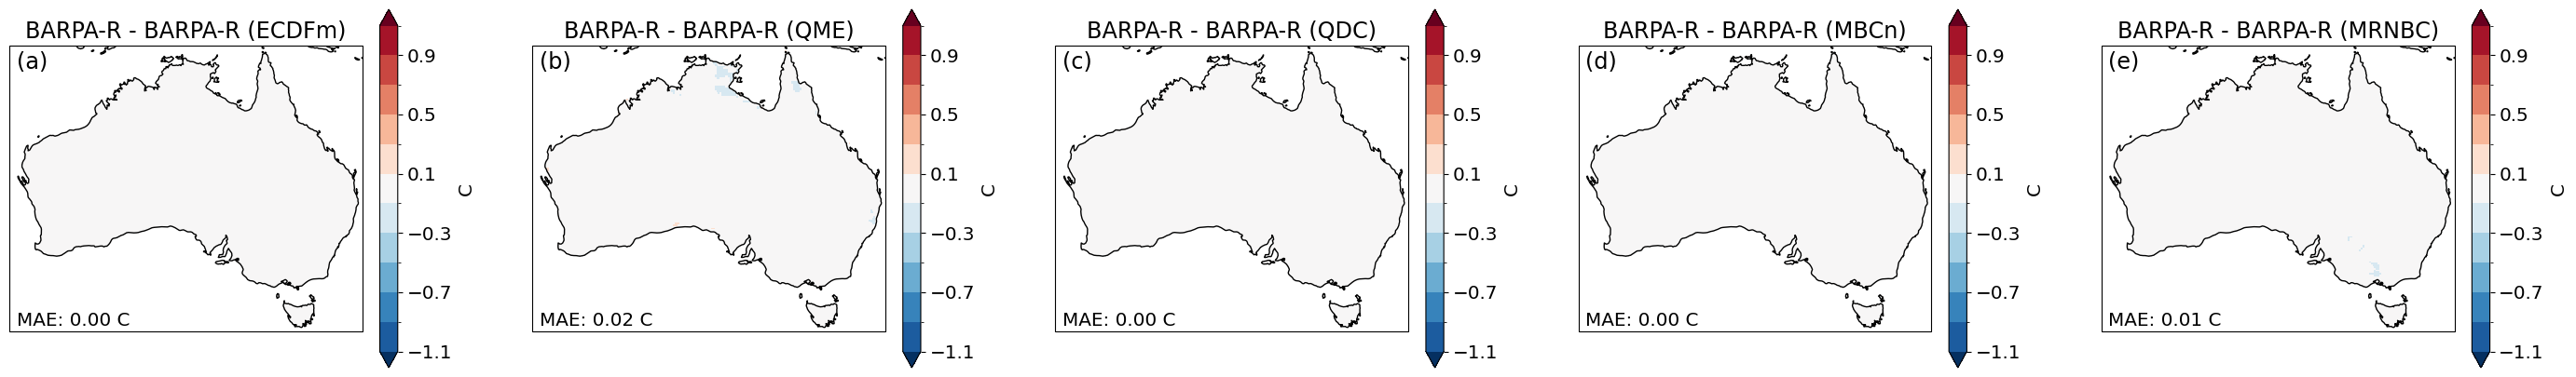

In [8]:
rcm = 'BOM-BARPA-R'
plot_comparison(
    variable,
    gcm,
    rcm,
    trend_cmap,
    diff_cmap,
    levels,
    rcm_levels,
    outfile=f'{outdir}{variable}_trend_task-projection_{gcm}_{rcm}.png',
    rcm_outfile=f'{outdir}{variable}_trend-rcm_task-projection_{gcm}_{rcm}.png',
)

change in annual mean daily maximum near-surface air temperature (2060-2099 minus 1980-2019)
/g/data/ia39/npcp/code/results/figures/tasmax_trend_task-projection_CSIRO-ACCESS-ESM1-5_CSIRO-CCAM-2203.png


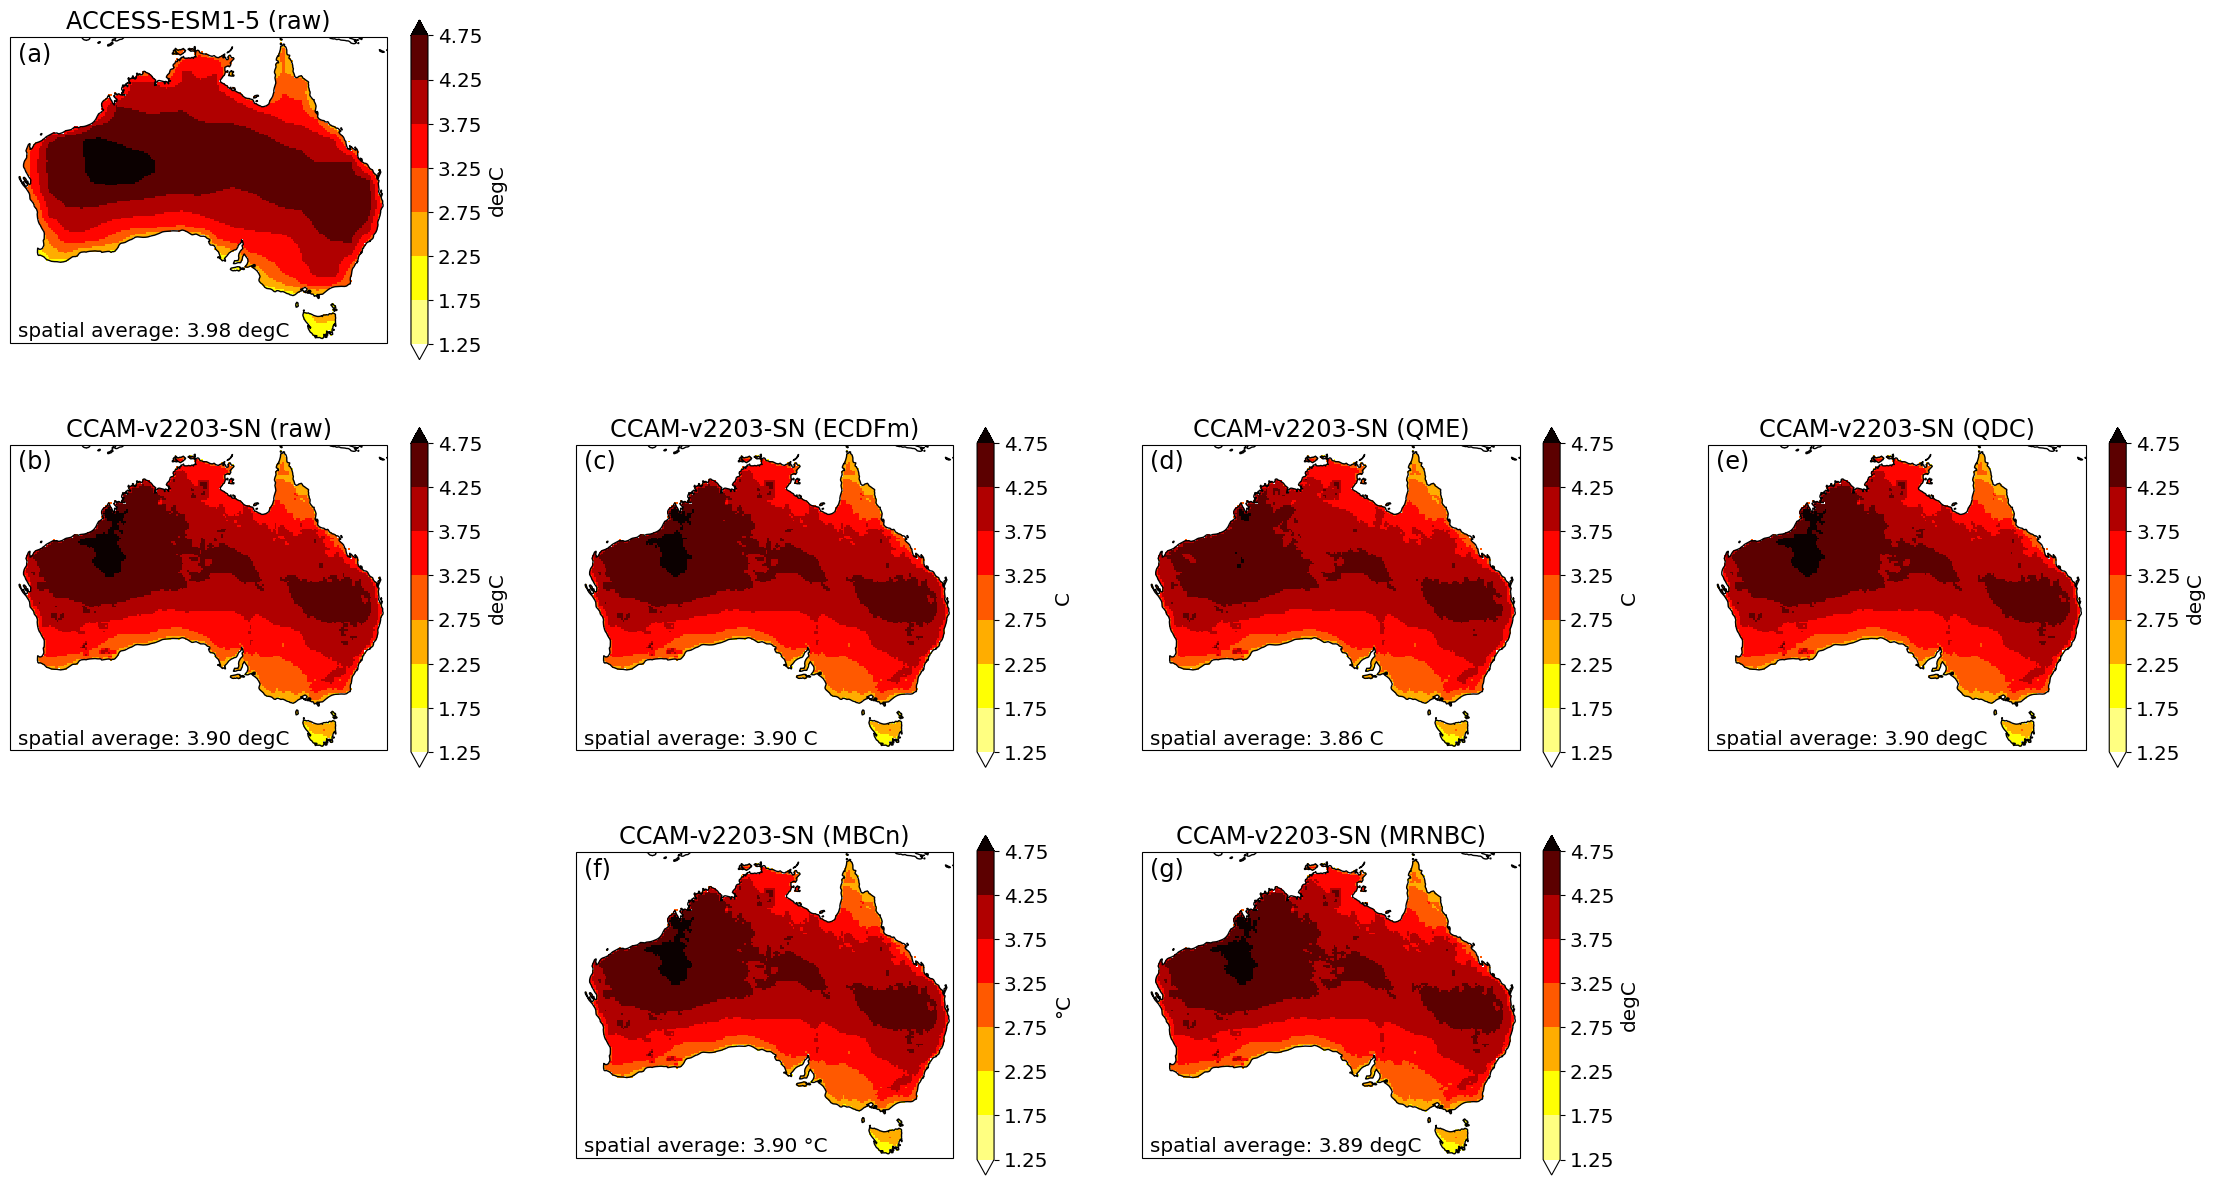

change in annual mean daily maximum near-surface air temperature relative to CSIRO-CCAM-2203-raw (bias-corrected RCM change minus raw RCM change)
/g/data/ia39/npcp/code/results/figures/tasmax_trend-rcm_task-projection_CSIRO-ACCESS-ESM1-5_CSIRO-CCAM-2203.png


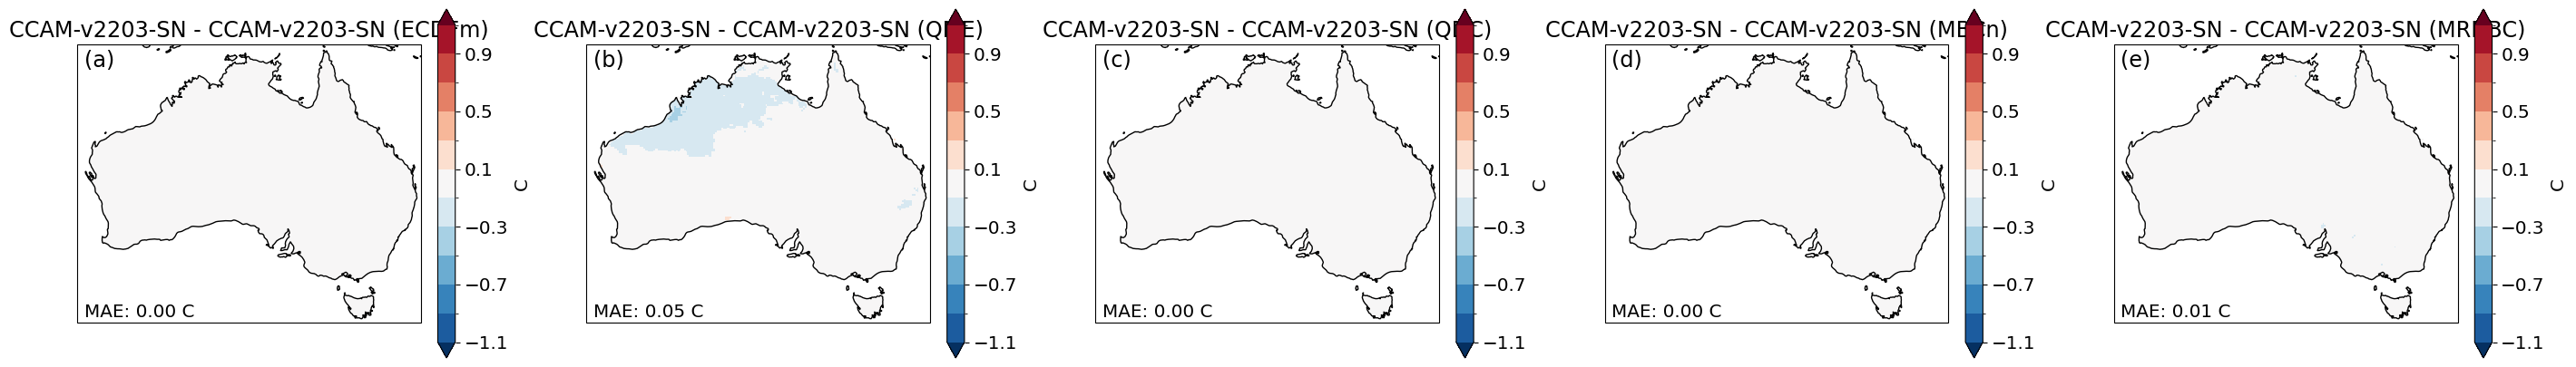

In [9]:
rcm = 'CSIRO-CCAM-2203'
plot_comparison(
    variable,
    gcm,
    rcm,
    trend_cmap,
    diff_cmap,
    levels,
    rcm_levels,
    outfile=f'{outdir}{variable}_trend_task-projection_{gcm}_{rcm}.png',
    rcm_outfile=f'{outdir}{variable}_trend-rcm_task-projection_{gcm}_{rcm}.png',
)

change in annual mean daily maximum near-surface air temperature (2060-2099 minus 1980-2019)
/g/data/ia39/npcp/code/results/figures/tasmax_trend_task-projection_CSIRO-ACCESS-ESM1-5_UQ-DES-CCAM-2105.png


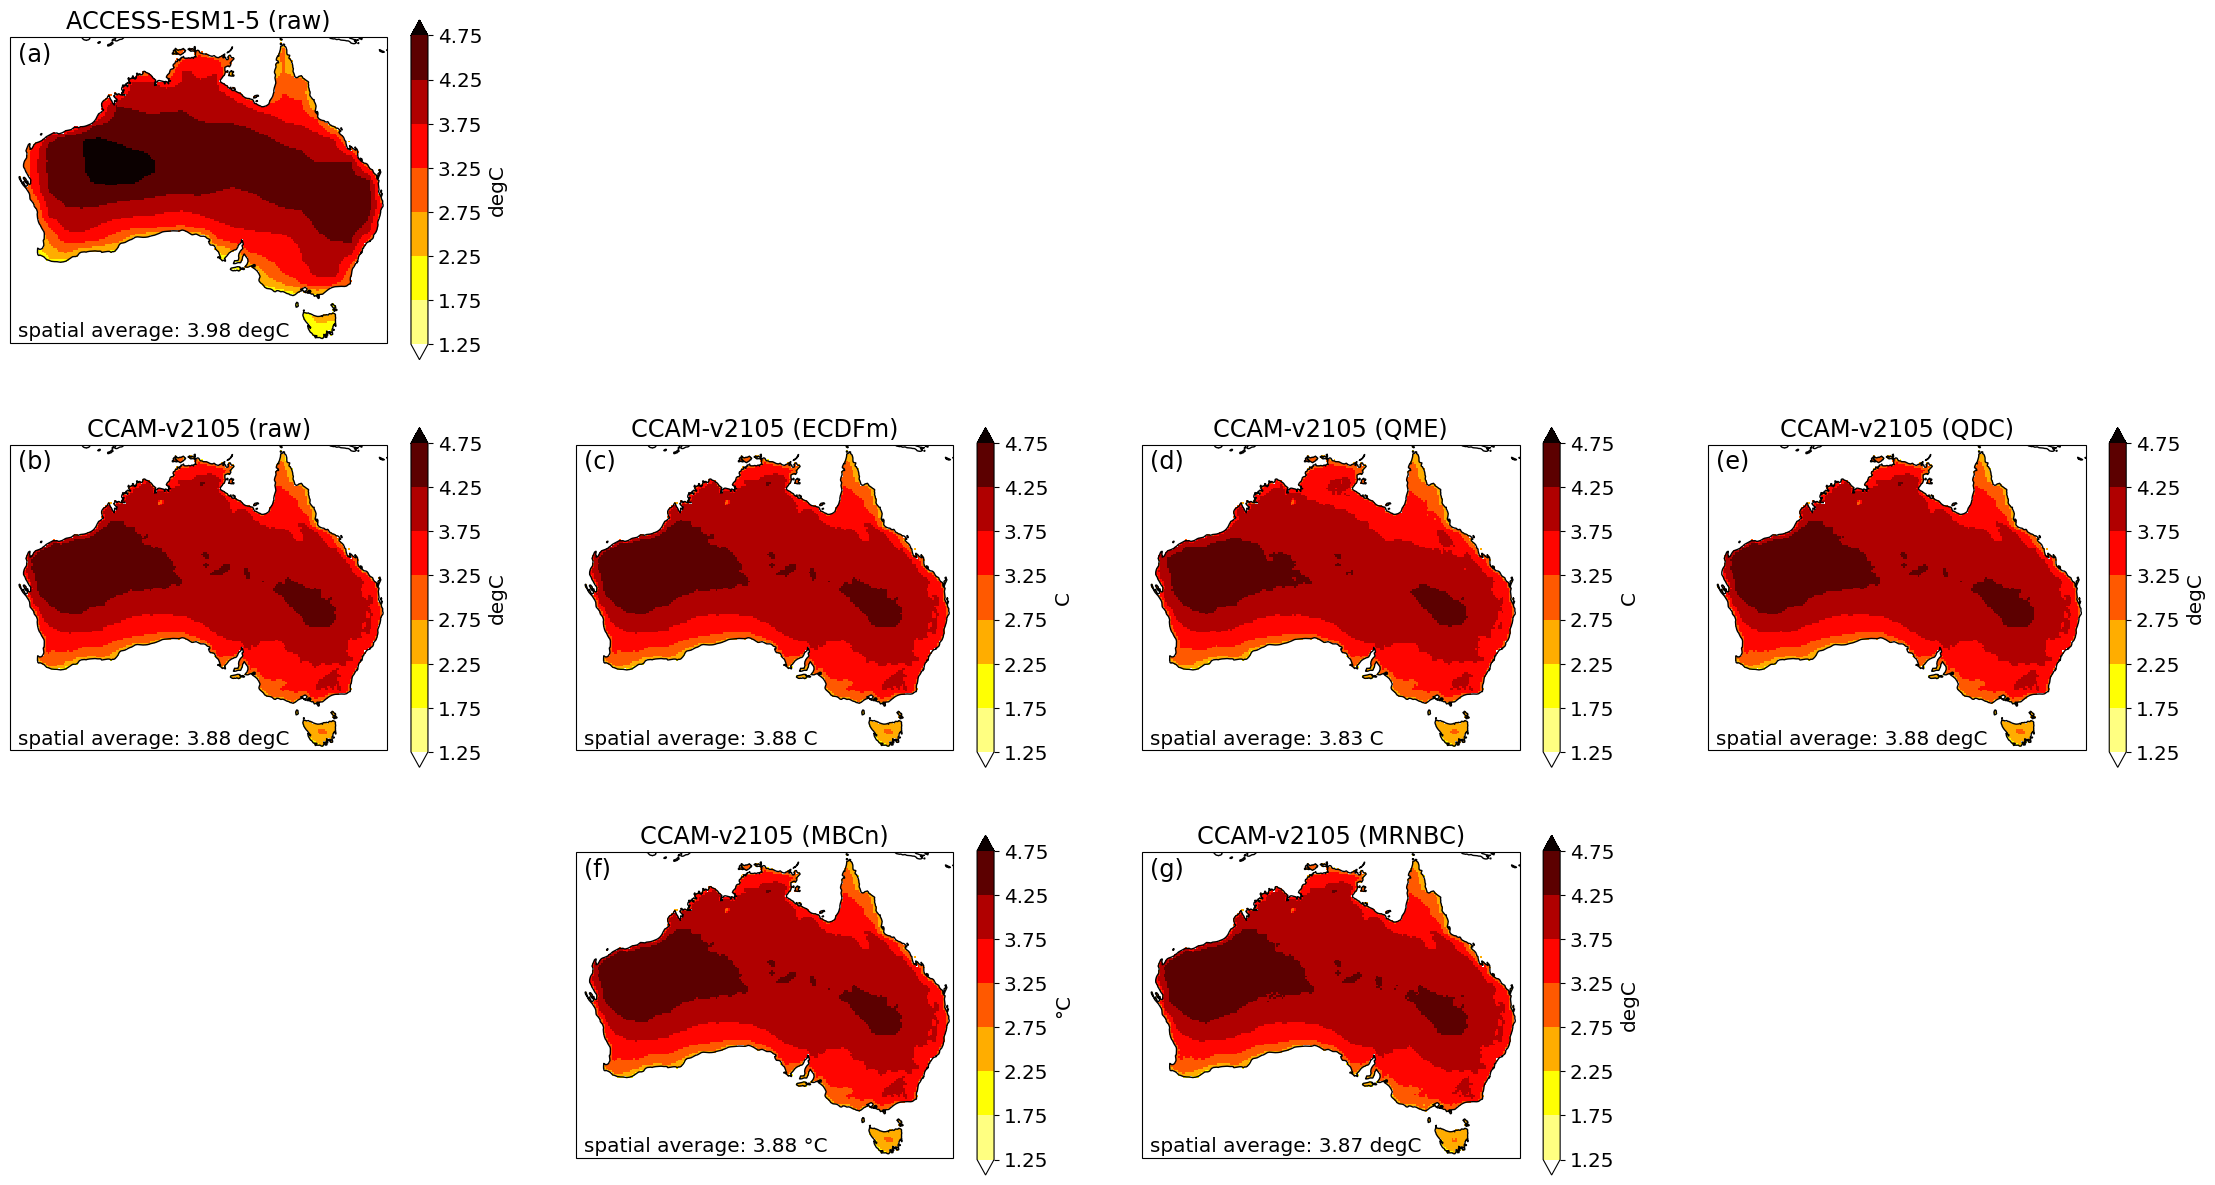

change in annual mean daily maximum near-surface air temperature relative to UQ-DES-CCAM-2105-raw (bias-corrected RCM change minus raw RCM change)
/g/data/ia39/npcp/code/results/figures/tasmax_trend-rcm_task-projection_CSIRO-ACCESS-ESM1-5_UQ-DES-CCAM-2105.png


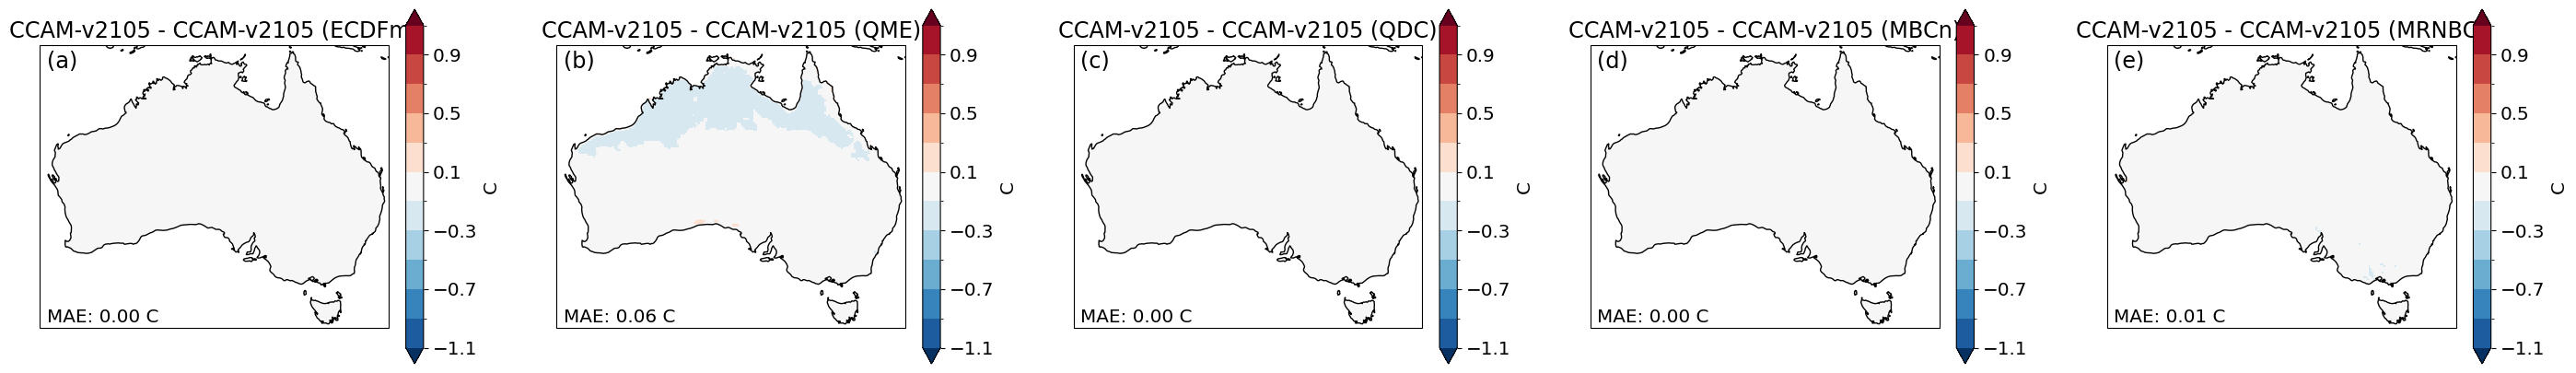

In [10]:
rcm = 'UQ-DES-CCAM-2105'
plot_comparison(
    variable,
    gcm,
    rcm,
    trend_cmap,
    diff_cmap,
    levels,
    rcm_levels,
    outfile=f'{outdir}{variable}_trend_task-projection_{gcm}_{rcm}.png',
    rcm_outfile=f'{outdir}{variable}_trend-rcm_task-projection_{gcm}_{rcm}.png',
)

#### CESM2

In [11]:
gcm = 'NCAR-CESM2'

change in annual mean daily maximum near-surface air temperature (2060-2099 minus 1980-2019)
/g/data/ia39/npcp/code/results/figures/tasmax_trend_task-projection_NCAR-CESM2_BOM-BARPA-R.png


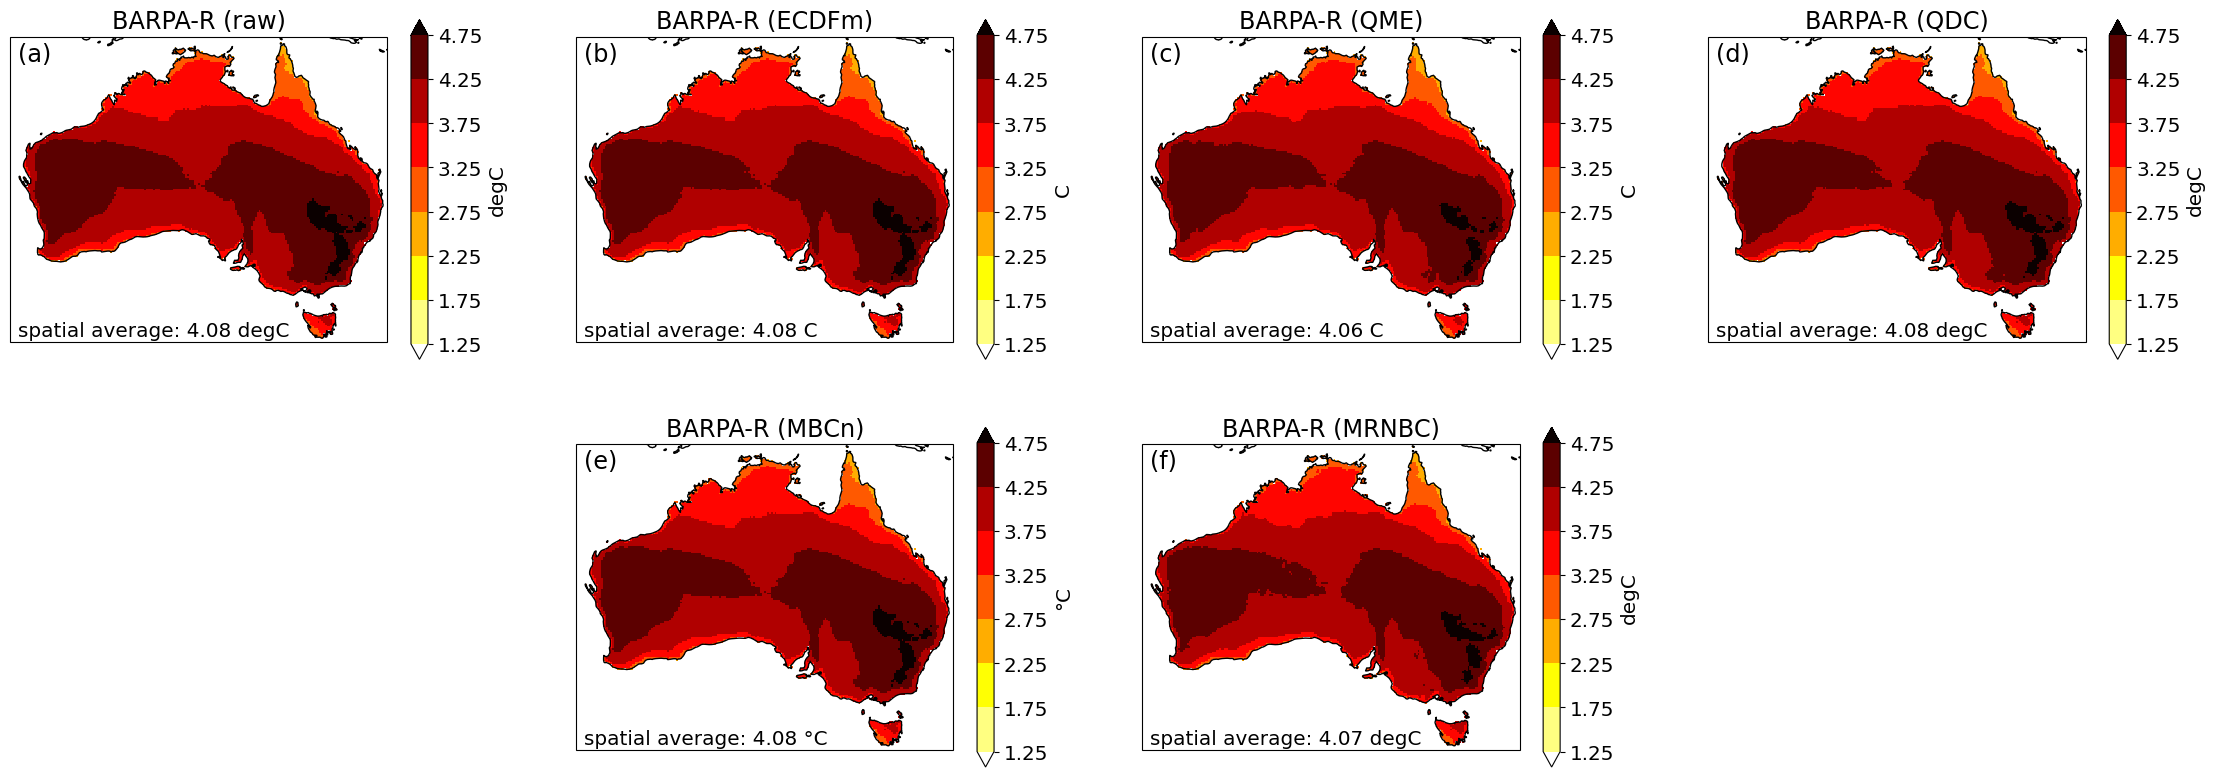

change in annual mean daily maximum near-surface air temperature relative to BOM-BARPA-R-raw (bias-corrected RCM change minus raw RCM change)
/g/data/ia39/npcp/code/results/figures/tasmax_trend-rcm_task-projection_NCAR-CESM2_BOM-BARPA-R.png


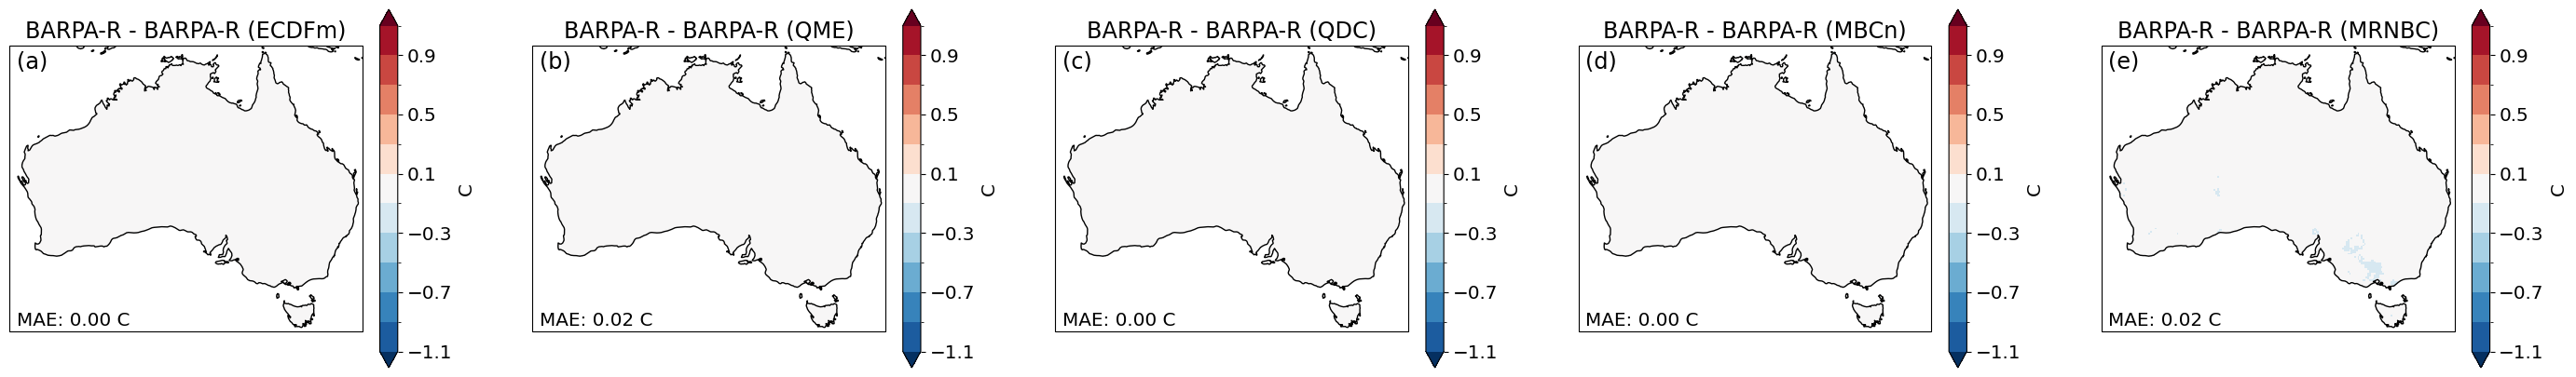

In [12]:
rcm = 'BOM-BARPA-R'
plot_comparison(
    variable,
    gcm,
    rcm,
    trend_cmap,
    diff_cmap,
    levels,
    rcm_levels,
    outfile=f'{outdir}{variable}_trend_task-projection_{gcm}_{rcm}.png',
    rcm_outfile=f'{outdir}{variable}_trend-rcm_task-projection_{gcm}_{rcm}.png',
)

change in annual mean daily maximum near-surface air temperature (2060-2099 minus 1980-2019)
/g/data/ia39/npcp/code/results/figures/tasmax_trend_task-projection_NCAR-CESM2_CSIRO-CCAM-2203.png


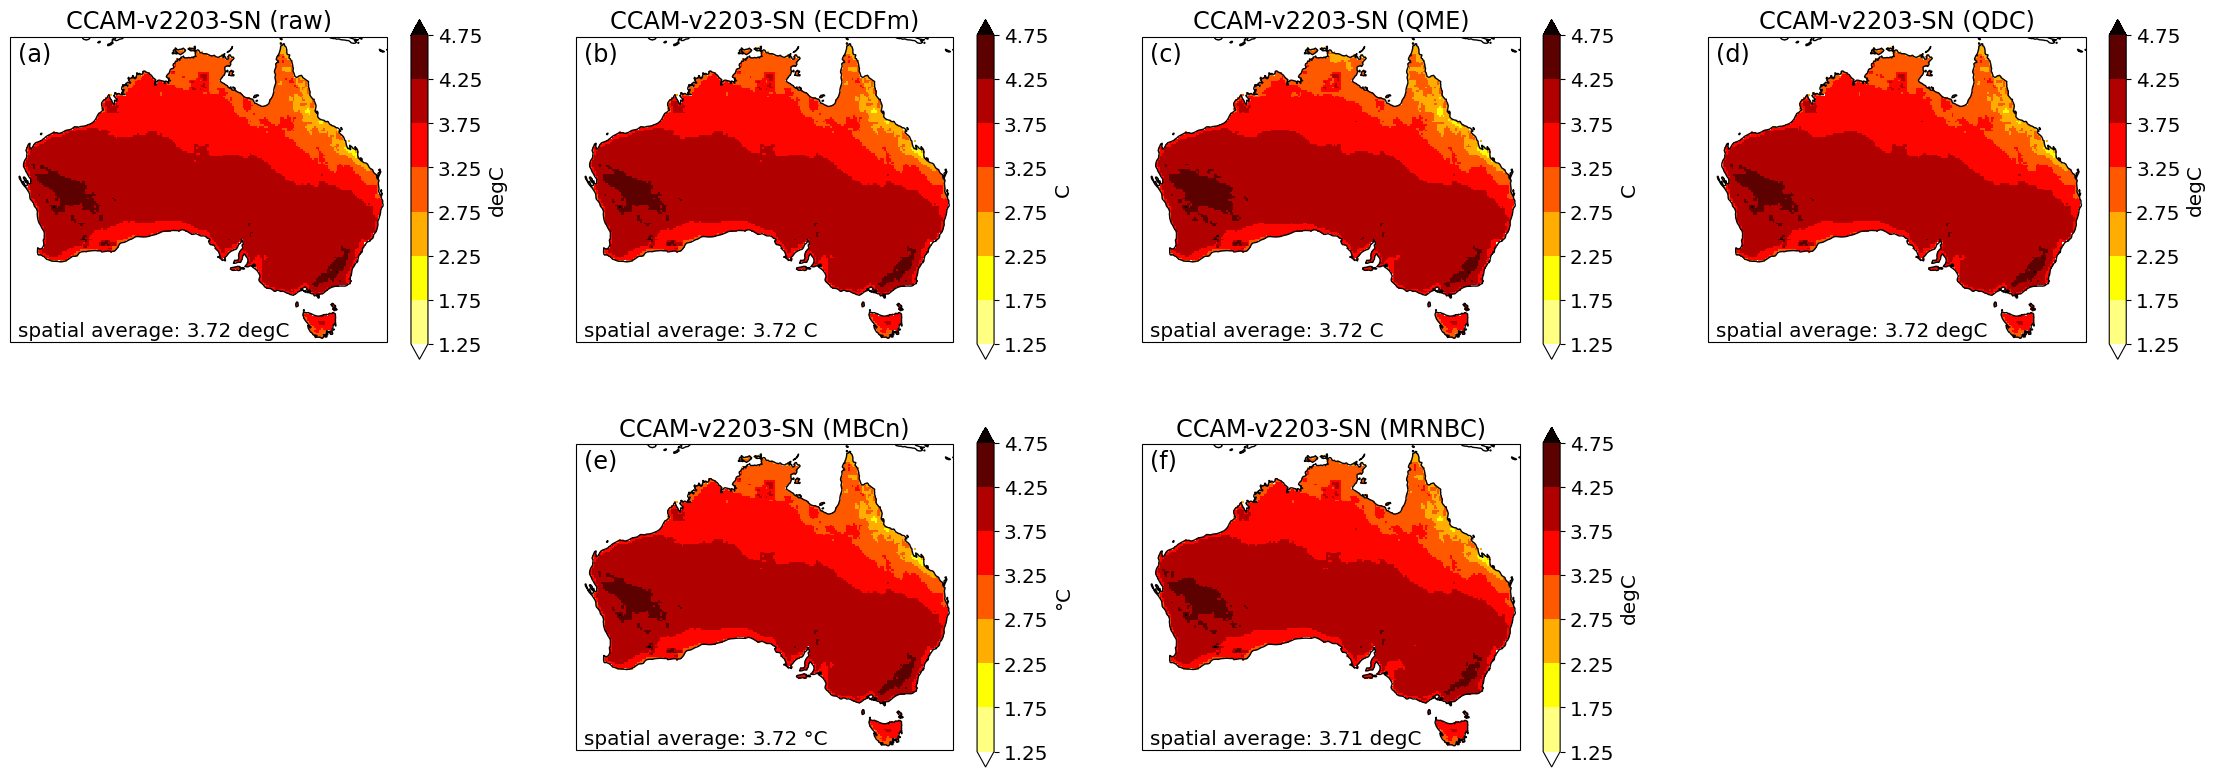

change in annual mean daily maximum near-surface air temperature relative to CSIRO-CCAM-2203-raw (bias-corrected RCM change minus raw RCM change)
/g/data/ia39/npcp/code/results/figures/tasmax_trend-rcm_task-projection_NCAR-CESM2_CSIRO-CCAM-2203.png


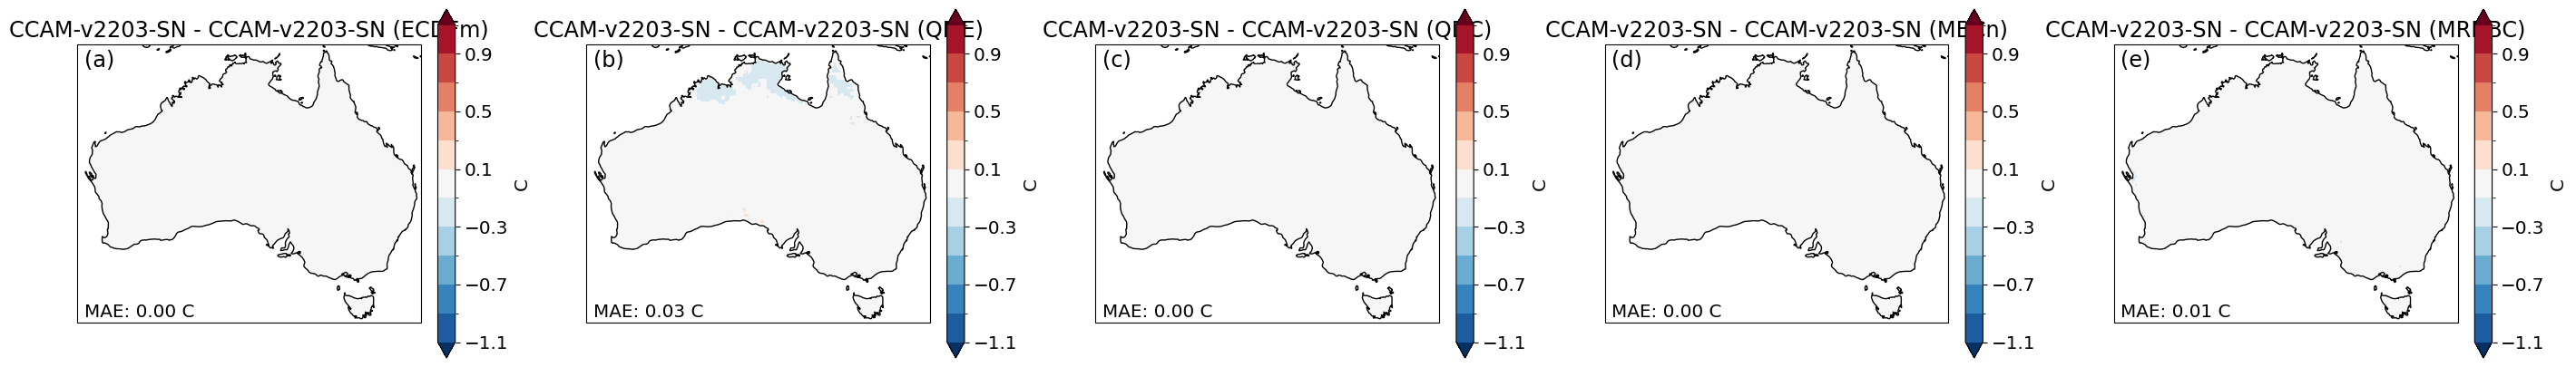

In [13]:
rcm = 'CSIRO-CCAM-2203'
plot_comparison(
    variable,
    gcm,
    rcm,
    trend_cmap,
    diff_cmap,
    levels,
    rcm_levels,
    outfile=f'{outdir}{variable}_trend_task-projection_{gcm}_{rcm}.png',
    rcm_outfile=f'{outdir}{variable}_trend-rcm_task-projection_{gcm}_{rcm}.png',
)

#### EC-Earth3

In [14]:
gcm = 'EC-Earth-Consortium-EC-Earth3'

change in annual mean daily maximum near-surface air temperature (2060-2099 minus 1980-2019)
/g/data/ia39/npcp/code/results/figures/tasmax_trend_task-projection_EC-Earth-Consortium-EC-Earth3_BOM-BARPA-R.png


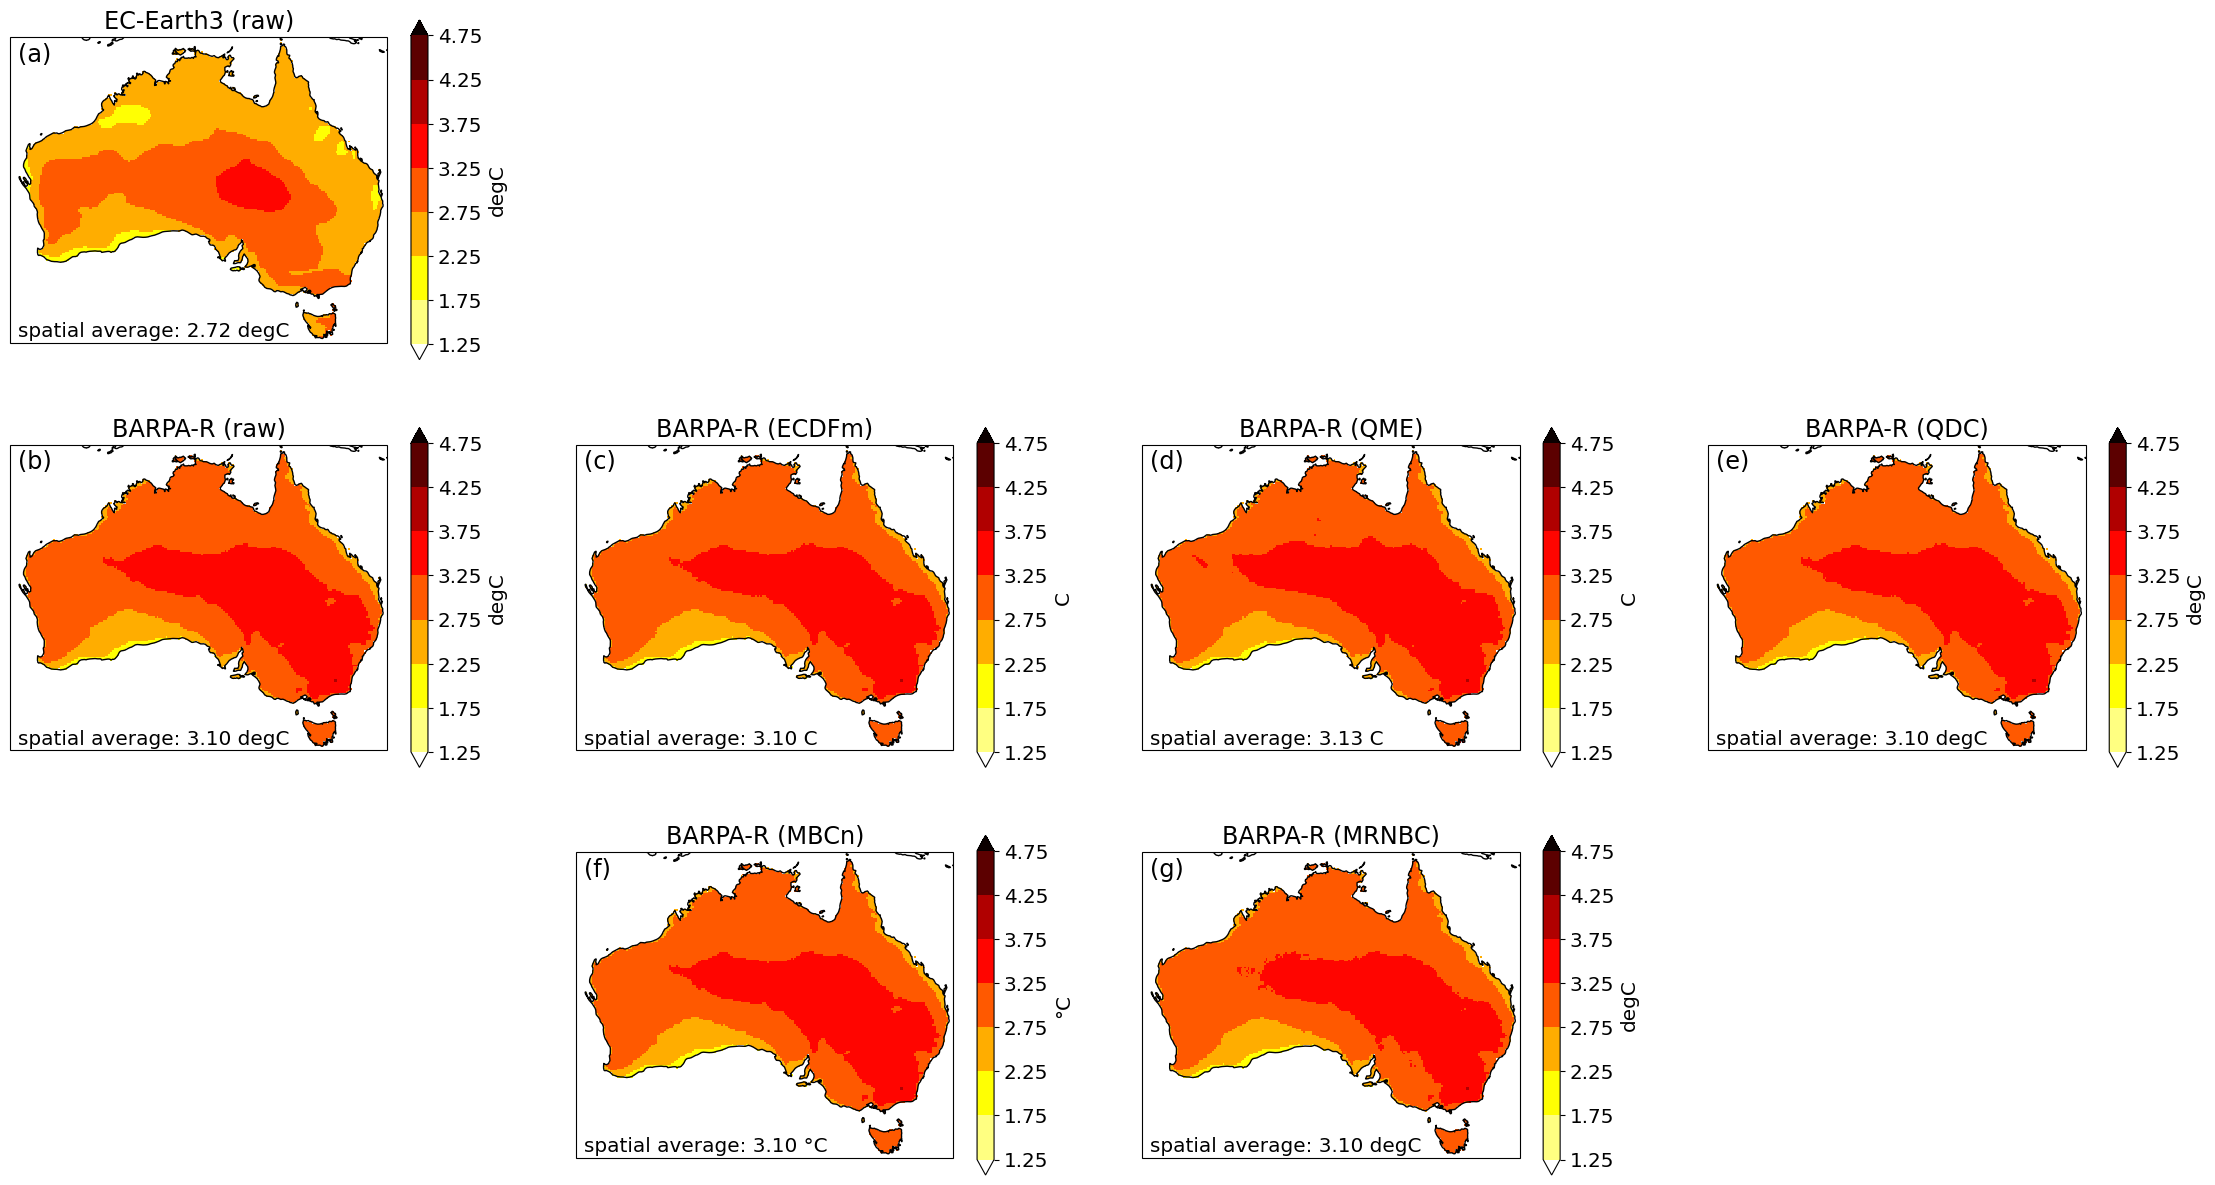

change in annual mean daily maximum near-surface air temperature relative to BOM-BARPA-R-raw (bias-corrected RCM change minus raw RCM change)
/g/data/ia39/npcp/code/results/figures/tasmax_trend-rcm_task-projection_EC-Earth-Consortium-EC-Earth3_BOM-BARPA-R.png


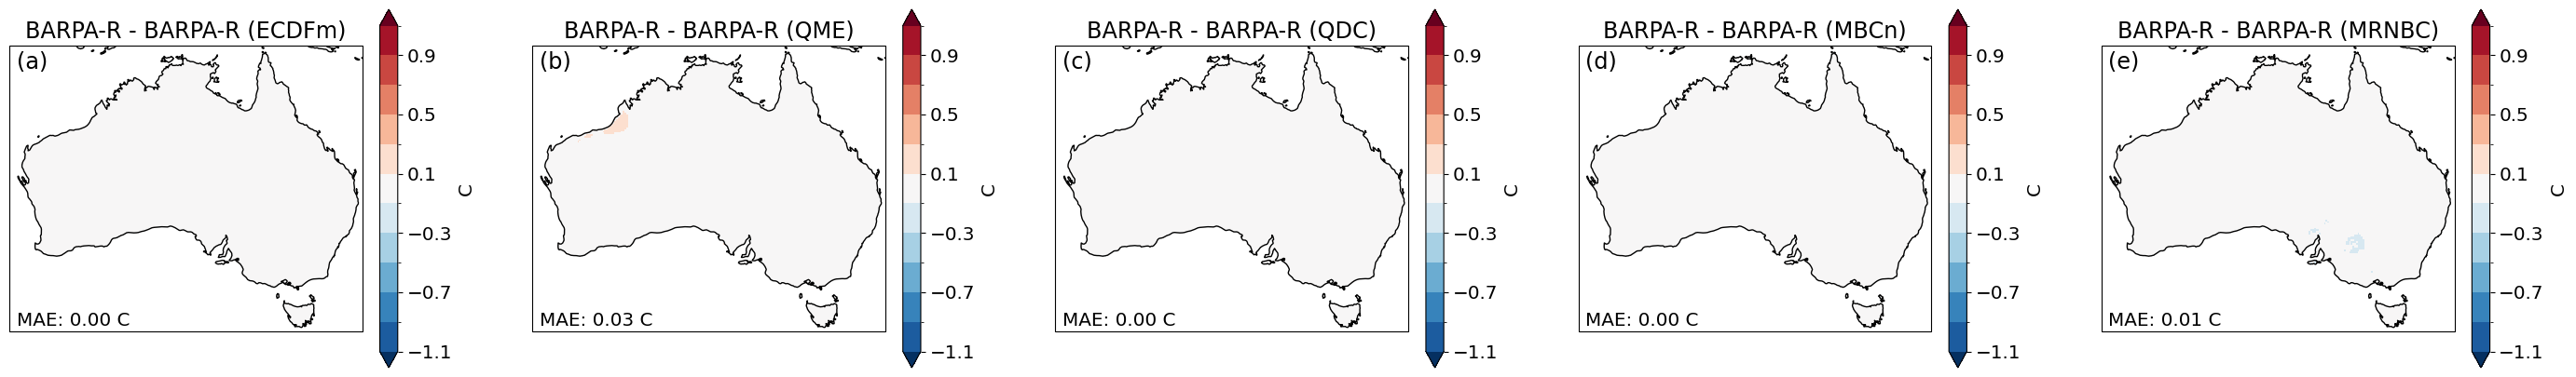

In [15]:
rcm = 'BOM-BARPA-R'
plot_comparison(
    variable,
    gcm,
    rcm,
    trend_cmap,
    diff_cmap,
    levels,
    rcm_levels,
    outfile=f'{outdir}{variable}_trend_task-projection_{gcm}_{rcm}.png',
    rcm_outfile=f'{outdir}{variable}_trend-rcm_task-projection_{gcm}_{rcm}.png',
)

change in annual mean daily maximum near-surface air temperature (2060-2099 minus 1980-2019)
/g/data/ia39/npcp/code/results/figures/tasmax_trend_task-projection_EC-Earth-Consortium-EC-Earth3_CSIRO-CCAM-2203.png


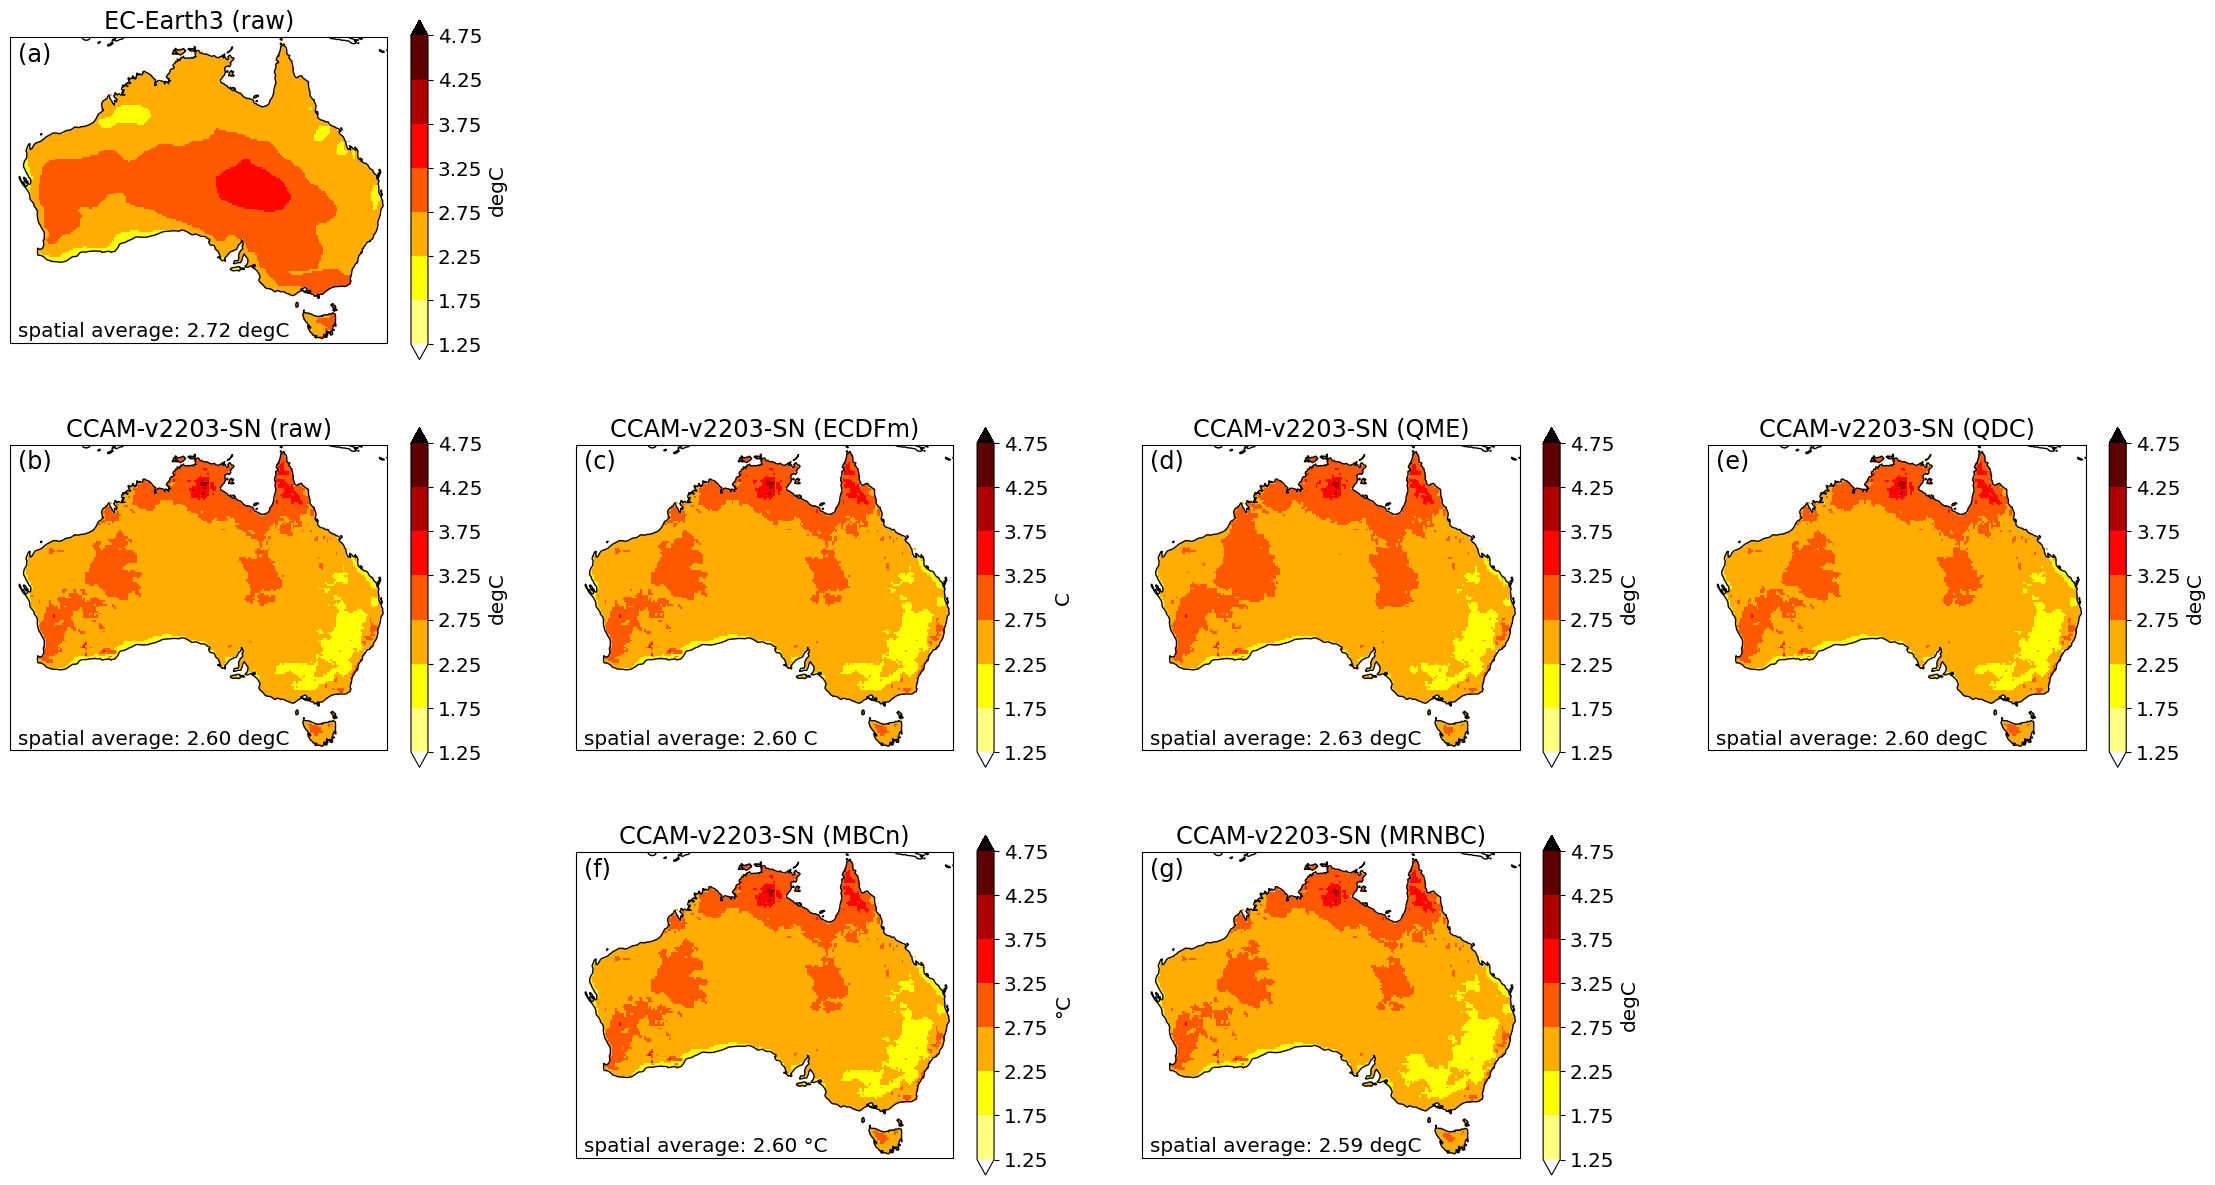

change in annual mean daily maximum near-surface air temperature relative to CSIRO-CCAM-2203-raw (bias-corrected RCM change minus raw RCM change)
/g/data/ia39/npcp/code/results/figures/tasmax_trend-rcm_task-projection_EC-Earth-Consortium-EC-Earth3_CSIRO-CCAM-2203.png


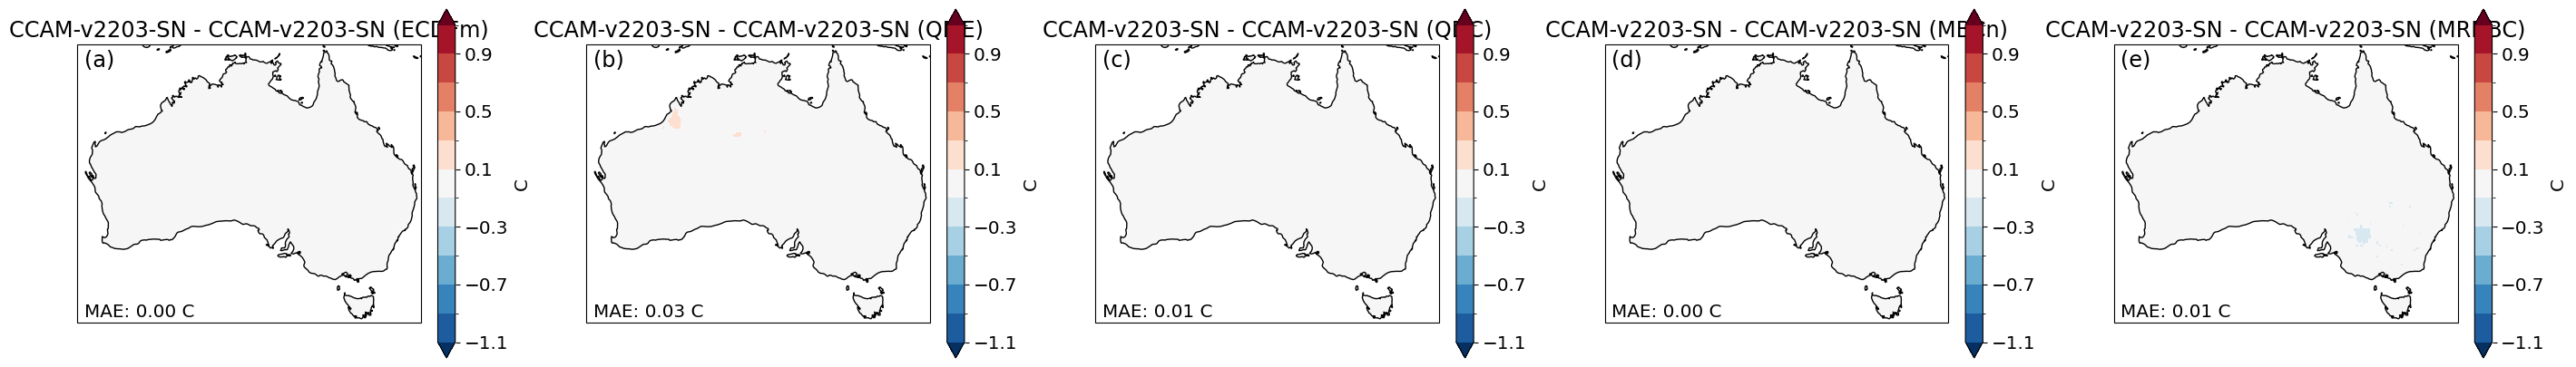

In [16]:
rcm = 'CSIRO-CCAM-2203'
plot_comparison(
    variable,
    gcm,
    rcm,
    trend_cmap,
    diff_cmap,
    levels,
    rcm_levels,
    outfile=f'{outdir}{variable}_trend_task-projection_{gcm}_{rcm}.png',
    rcm_outfile=f'{outdir}{variable}_trend-rcm_task-projection_{gcm}_{rcm}.png',
)